<a href="https://colab.research.google.com/github/piziomo/Trainings/blob/main/Transformers_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IM954 Week 07: Introduction to Transformers

In the previous lab we built an RNN (Recurrent Neural Network)-based  character-level text generator. It was trained on a Shakespeare dataset, generating a play-like text.

Until 2017, RNN-style models were considered the most advanced approach to dealing with text data. In 2017, Vaswani et al. published the "Attention is All You Need" paper introducing a new **Transformer** model architecture that outperformed other approaches in language translation tasks.


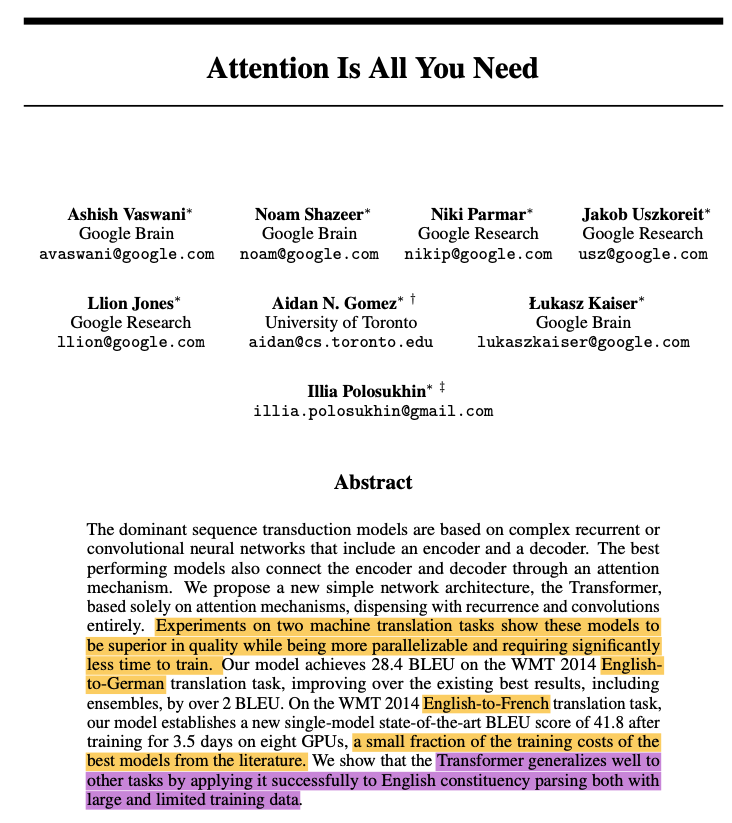

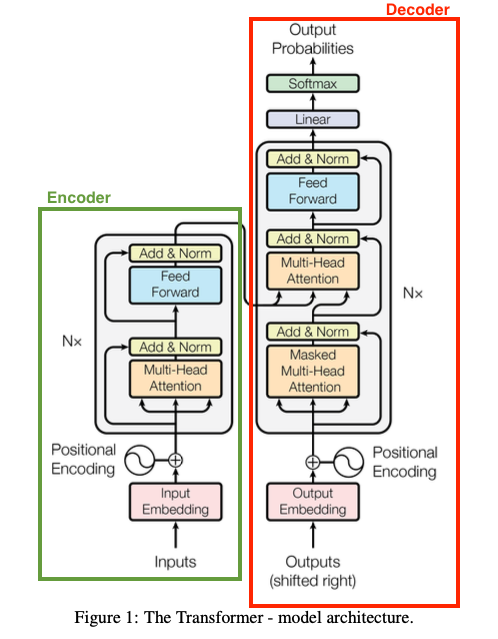

**Why did the transformer architecture outperform RNN-based models?** There are a couple of reasons:
1. The Transformer architecture allows parallelization.
  - This means that instead of going through one token (word or character) in a sequence at a time, it processes all the input tokens at once. Thus, it takes less time to train the data, which becomes a problem when training RNN-based models on a lot of data.
2. The Transformer achitecture reduces information loss.
  - RNNs compress all the information about a sequence into a single state vector, thus loosing contextual information. Transformers, on the other hand, place different emphasis (weights) on different words as they relate to the word in question. This is based on the idea that not every word in a sentence is of equal importance in the meaning-making process.

Let's illustrate the second (2.) point with an example from Foster's (2023) textbook. Read the sentence below

> The pink elephant tried to get into the car but the elephant was too [...].

What word did you use to complete the sentence? Why?

There are specific words in the sentence that signal to you the potential way(s) of finishing the sentence. For example, you might have noticed the "elephant" which you associate with some adjectives (e.g. big) but not others (e.g. small). Also, it is likely that the word "elephant" was more relevant than, let's say, the word "to" when completing the sentence.

The Transformer architecture's self-attention mechanism aims to do something like this -- attribute different importance scores to different words in an input sequence. It then reapplies this strategy successively throughout multiple layers from input to output.

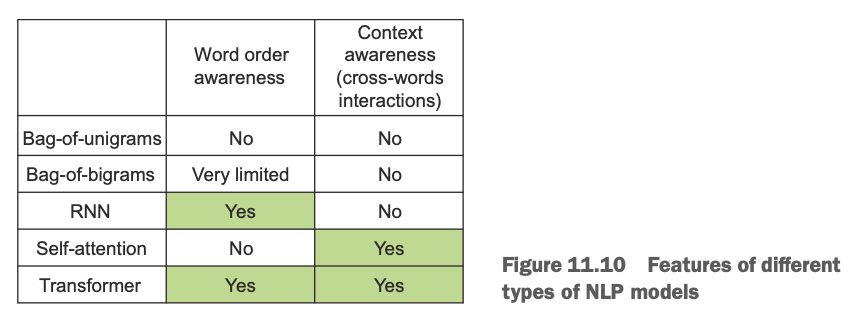

## GPT

GPT (Generative Pre-trained Transformer) was [introduced by OpenAI](https://openai.com/research/language-unsupervised) in 2018. GPT is a *decoder*, not encoder-decoder as in the original transformer illustration. Decoder is for text generation.

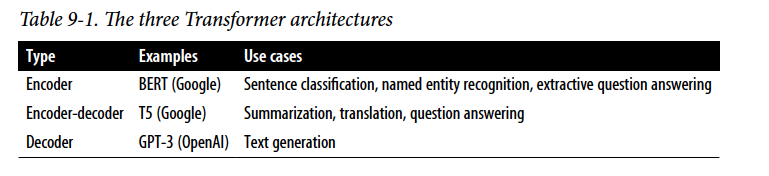

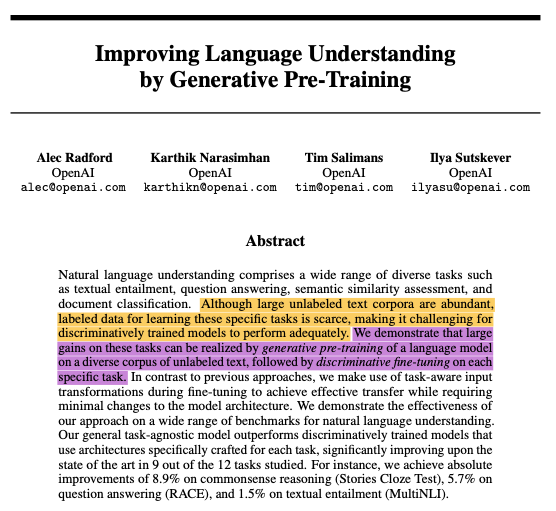

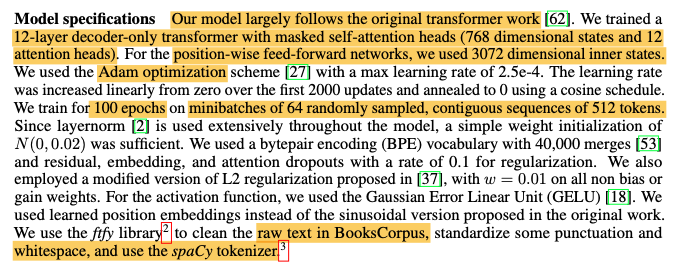

## This week we will...


This week, we will build a variation of a GPT model, which will be trained to generate wine reviews.

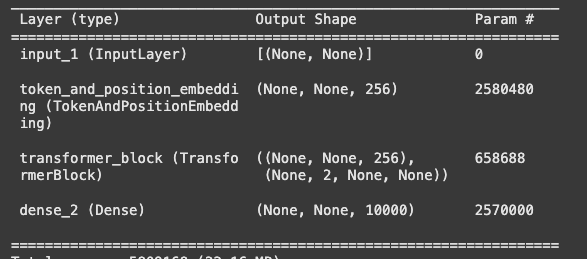

We will train our model to generate wine reviews 🍷

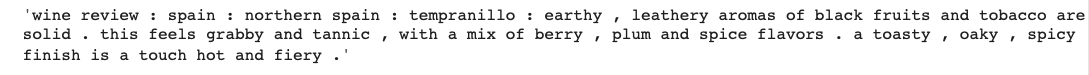

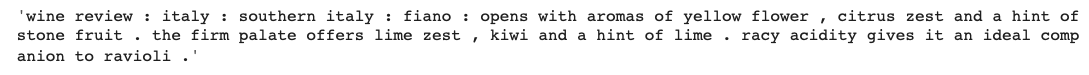

## Wine dataset

To generate wine reviews, we will train the GPT on 130k wine reviews scraped from the website [wineenthusiast.com](https://www.wineenthusiast.com/?s=&search_type=ratings&drink_type=wine) in 2017.

You can read more about the dataset here: https://www.kaggle.com/datasets/zynicide/wine-reviews?resource=download

In [ ]:
import numpy as np
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

In [ ]:
# Let's define the global variables (variables outside the function)
VOCAB_SIZE = 10000 # vocabulary size
MAX_LEN = 80 # maximum number of tokens
EMBEDDING_DIM = 256 # embedding vector length
KEY_DIM = 256 # key vector length
N_HEADS = 2 # number of multi-attention heads
FEED_FORWARD_DIM = 256 # feed forward vector length
SEED = 42
BATCH_SIZE = 32
EPOCHS = 5

### Download

In [ ]:
# download the wine dataset
!pip install gdown

import gdown

file_id = "1MxO82gJ_-GxUFcVNpz29nDdGpnh0WBDL"
output_file = "wine-dataset.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

!unzip -qq /content/wine-dataset.zip -d wine-dataset

Downloading...
From (original): https://drive.google.com/uc?id=1MxO82gJ_-GxUFcVNpz29nDdGpnh0WBDL
From (redirected): https://drive.google.com/uc?id=1MxO82gJ_-GxUFcVNpz29nDdGpnh0WBDL&confirm=t&uuid=759b6c73-c5fa-4754-8f05-0b7a7c2200a3
To: /content/wine-dataset.zip
100%|██████████| 52.5M/52.5M [00:00<00:00, 237MB/s]


replace wine-dataset/__MACOSX/._wine-dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load the dataset
with open("/content/wine-dataset/wine-dataset/winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)

### Explore data + intro to dictionaries



In [ ]:
# Look at the dataset type
print(f" Wine dataset type: {type(wine_data)}")

# Check how many reviews are in the wine dataset
print(f" Review count: {len(wine_data)}")

# Look at the data type of a single review
print(f" Review data type: {type(wine_data[1])}")

NameError: name 'wine_data' is not defined

In [ ]:
# print a review
wine_data[1]

{'points': '87',
 'title': 'Quinta dos Avidagos 2011 Avidagos Red (Douro)',
 'description': "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
 'taster_name': 'Roger Voss',
 'taster_twitter_handle': '@vossroger',
 'price': 15,
 'designation': 'Avidagos',
 'variety': 'Portuguese Red',
 'region_1': None,
 'region_2': None,
 'province': 'Douro',
 'country': 'Portugal',
 'winery': 'Quinta dos Avidagos'}

The wine_dataset is a list of dictionaries. A dictionary is a data type used for storing key:value pairs. The key is a description, you can think of it as a column name in a table. Value tells the value stored in the key, you can think of it as a value stored in a cell of a row.

A dictionary here is used to describe a particular wine review or, more precisely, to store data values about a particular review.

You can learn about the dictionaries here: https://www.w3schools.com/python/python_dictionaries.asp

#### A brief digression... on sociology of classification

Have you ever thought why things are classified in certain ways? How important is classification in your everyday life? What does it do? Classification is a way of making and knowing about the world. This is what G. Bowker and S. Leigh Star (2000, p.6) say about classification: "We have a moral and ethical agenda in our querying of these systems. Each standard and each category valorizes some point of view and silences another. This is not inherently a bad thing-indeed it is inescapable. But it is an ethical choice, and as such it is dangerous-not bad, but dangerous."

Classification system does not emerge out of nowhere, it is constructed and practiced and it is historically and culturally contingent. For example, think about the different logics behind French and Californaian wine classification systems (taken from Mary Douglas' *How Institutions Think*)

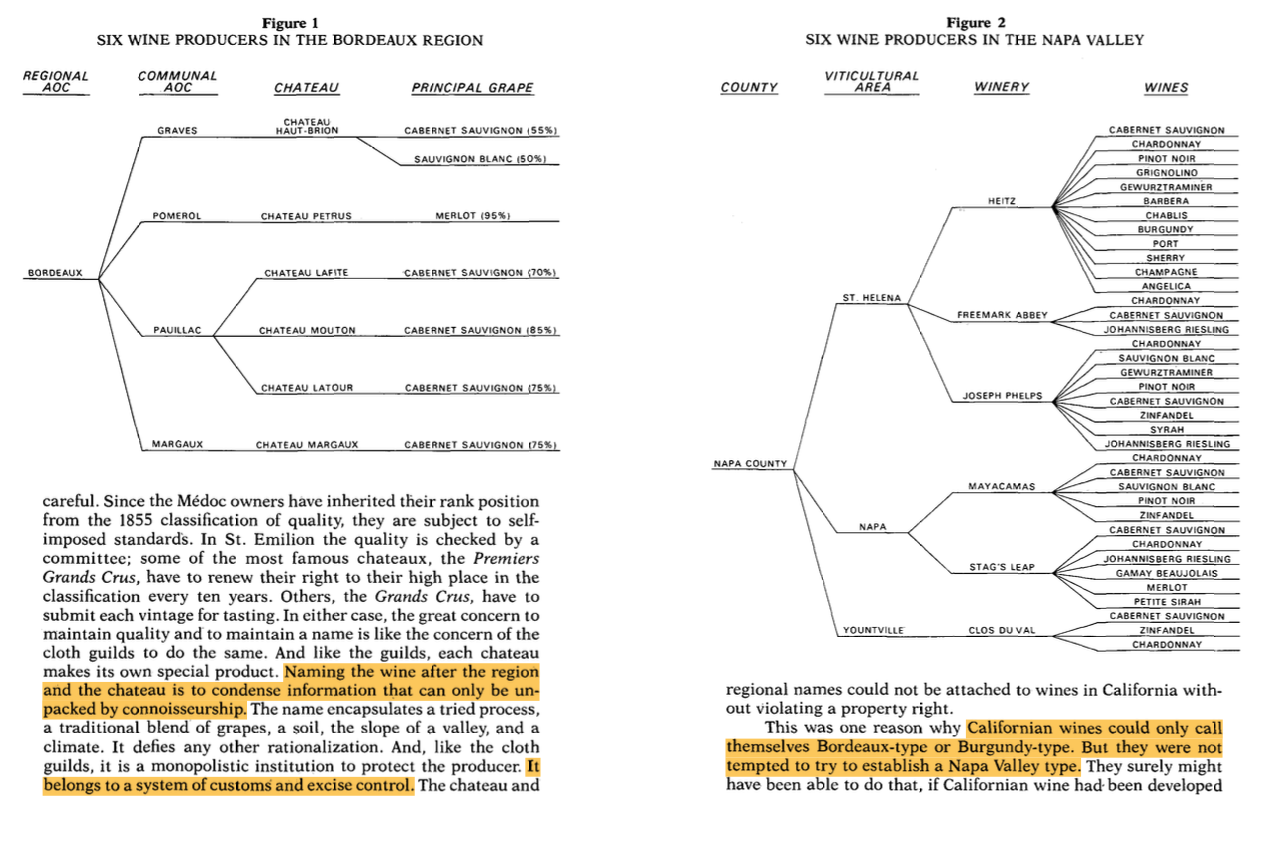

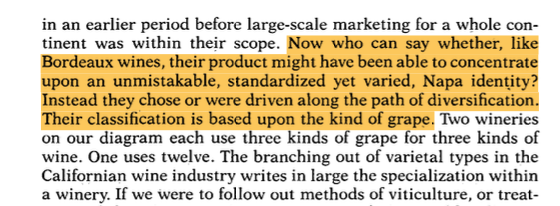

If we compare French and Californiaian wine classifications to wine classification in our dataset, what is made explicit?

I would suggest that, for example, French classification implies tacit knowledge about wine which a model cannot know about unless it is spelled out (think of taste).

You can take this further to inquire about art. Who is classified as an artist and/or an author? How does it vary across cultures? If AI models can be creative, in what way? What kind of art might be "inaccessible" to them without embodiment (can they do performative art?)? How can we explore the limits of AI creativity once we start paying attention to different kinds of artistic practices?

### Filtering

Next, we will *filter* our dataset by removing some of the information that we think is not relevant. Additionally, we will make sure that only those reviews that have complete information remain in our final--filtered--dataset.

We will keep the following information: country, province, variety, and description. You could keep other key-value pairs. Remember that we will train our model on the filtered data, so if you remove price key then the generated reviews will not have price-related information. Also, we will limit the length of an input sequence (a single review) to 80 tokens, so if the review is longer than this, it will be trimmed automatically. The length of an input sequence can be modified by changing the value of MAX_LEN variable.

In [ ]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    + " : "
    + str(["price"])


    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [ ]:
# Count the recipes
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


In [ ]:
filtered_data[25]

"wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture. : ['price']"

### Data tokenization

As with the RNNs, we must vectorize our text data, so it can be inputed to the model.

We have to complete the following steps:
1. Pad punctuation with spaces, so that each punctuation mark is treated as a separate word.

2. Pass the strings through a TextVectorization layer that tokenizes the data and pads/clips each string to a fixed length.

#### Pad punctuation

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
# to do this, we will add a space before each puntuation mark.
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s

text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
# check whether text data is in the expected format
text_data[25]

"wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . : [ ' price ' ] "

In [ ]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(32) # batch size is 32
    .shuffle(1000)
)

#### Vectorisation

In [ ]:
# Create a vectorisation layer which:
# 1. converts the input text to lowercase;
# 2. has a maximum number of tokens equal to the vocabularly size;
# 3. has an integer output type;
# 4. specify maximum length of an output; this will ensure that our reviews are of equal length.
MAX_LEN = 80
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=10000, # vocab size is 10000
    output_mode="int",
    output_sequence_length=MAX_LEN + 1, # MAX_LEN = 80
)

Now we will have to "adapt" the vectorize_layer. This means that the layer will build a vocabulary of all string tokens seen in the dataset, sorted by occurrence count, with ties broken by sort order of the tokens (high to low).

For more on TextVectorization and adapt() see official documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [ ]:
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:15]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: '
7: the
8: wine
9: a
10: of
11: price
12: review
13: ]
14: [


In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(filtered_data[25])
print(example_tokenised.numpy())

[   8   12    2   23    2   32    2   46   65    2   58    5  246 4147
  455  636   29   10  499  501  669   21   16    1   46   28 2486   35
    9    1    1  596   21    1   19   78    1    1  100    5   77 2635
   21  201   52    5  128    1    2    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
len(example_tokenised)

81

## Construct training set

To train an RNN model, we worked with two vectorised sequences of strings: input and target sequences. We will do the same to train GPT.

Our training set will be consist of a) input sequence (the original wine review)
b) sequence of outputs to predict (shifted by one; the first token will be known to the model, so it can start a prediction. You can think of it as a "prompt".)


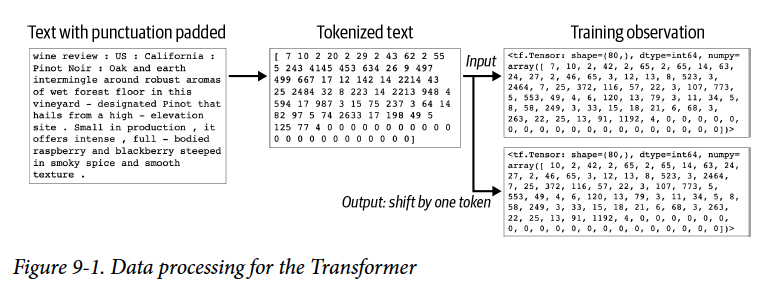

In [ ]:
# Create the training set of a) recipes and b) the same text shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:] # shifting by one word
    return x, y

train_ds = text_ds.map(prepare_inputs)

In [ ]:
example_input_output = train_ds.take(1).get_single_element()
example_input_output[0][25]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   8,   12,    2, 4231,    2, 4231,    2,   95,   18,   48,   47,
          2,   29,   10,   39,    5,   89, 1191,   22,    7,   31,  170,
         53,   10, 1418,    3,  618,  378,    5,  320,   27,   93,    4,
          9,   74,   18,  112,    8,    3,   15,   20,   28,   42, 1073,
       1151,   99,    5,  177,    3,    7,   34,  635,  399,   37,    5,
         90,   33,    4,  127, 1621, 3841,    3,    1, 3594,    4,    2,
         14,    6,   11,    6,   13,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [ ]:
# Example output (shifted by one word)
example_input_output[1][25]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  12,    2, 4231,    2, 4231,    2,   95,   18,   48,   47,    2,
         29,   10,   39,    5,   89, 1191,   22,    7,   31,  170,   53,
         10, 1418,    3,  618,  378,    5,  320,   27,   93,    4,    9,
         74,   18,  112,    8,    3,   15,   20,   28,   42, 1073, 1151,
         99,    5,  177,    3,    7,   34,  635,  399,   37,    5,   90,
         33,    4,  127, 1621, 3841,    3,    1, 3594,    4,    2,   14,
          6,   11,    6,   13,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

## Create Token and Position Embedding

For an RNN model, we performed so-called *token embedding* to create a numeric representation of a character. We will use the same technique to convert **words**, present in the wine reviews dataset, to vectors.

Additonally, we will encode the *position* of a word. This will mitigate the problem related to parallelisation -- elimination of the order of words because the processing of all the tokens happens at once rather than sequentially as in the RNNs.

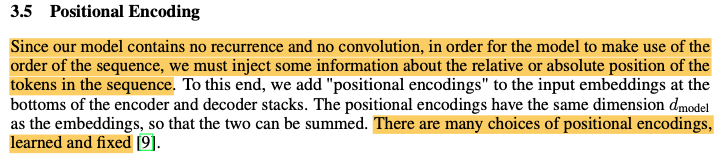

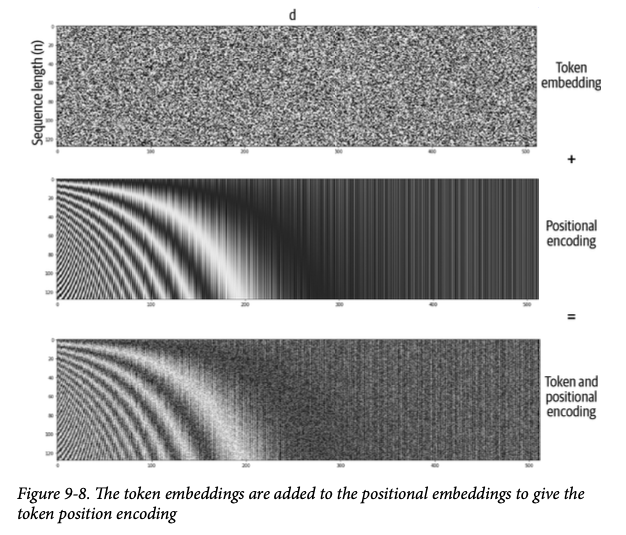

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        MAX_LEN= tf.shape(x)[-1]
        positions = tf.range(start=0, limit=MAX_LEN, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

    @classmethod
    def from_config(cls,config):
        return cls(**config)

## Create a Transformer Block layer

A *transformer block*, or a layer, is a single component in a Transformer. Our model will have one such block, but you could stack several of them. For example, the original GPT is a 12-block transformer.

Why would you want to have a stack of blocks? It seems that each block attends to different parts of the input as research on attention in BERT (which is an encoder) suggests (see Clark et al. 2019). In this sense, you could think that stacking transformer blocks is like adding several convolutional layers for capturing different spatial information in an image.


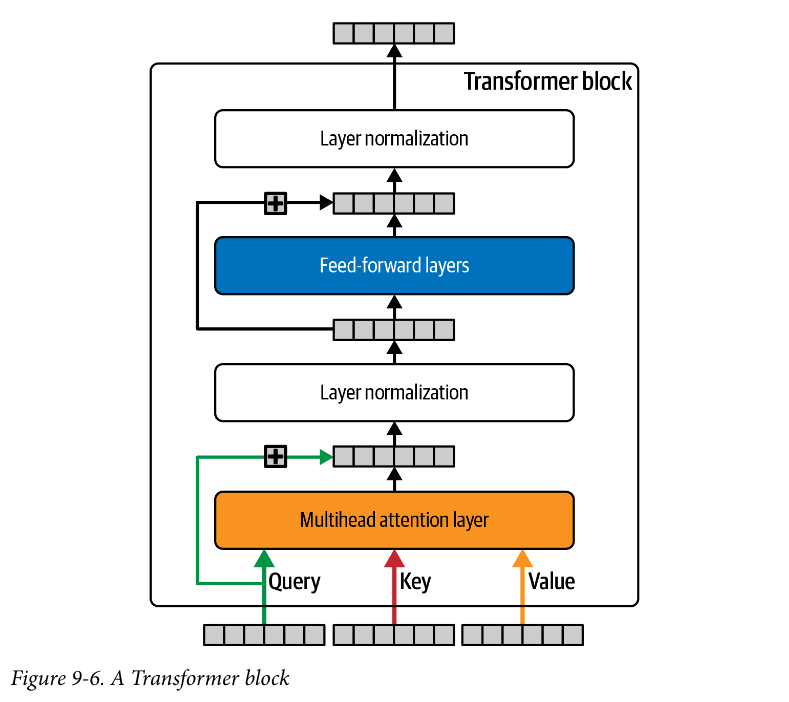

### Self-attention mechanism

The major innovation in the Transformer architecture is that it solely relies on self-attention mechanism (e.g. no recurrence as in RNNs). The attention layer is where the model learns to give more weight to some input words but not others.

Wasvan et al. (2017) list 4 (3 main and 1 additional) reasons for using self-attention mechanism

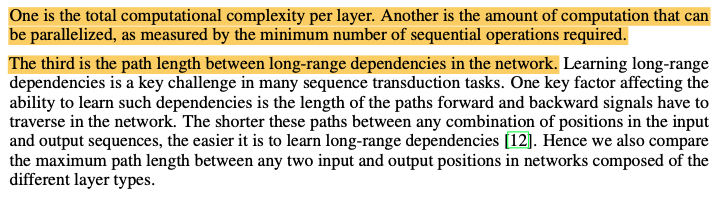

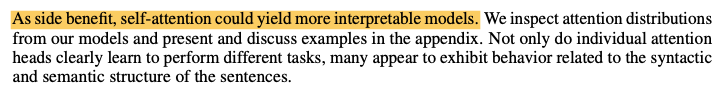

We will also attempt to interpret our model's inputs by visualising attention distribution. If you're interested, you can play around with, for example, this interactive visualisation: https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb#scrollTo=OJKU36QAfqOC

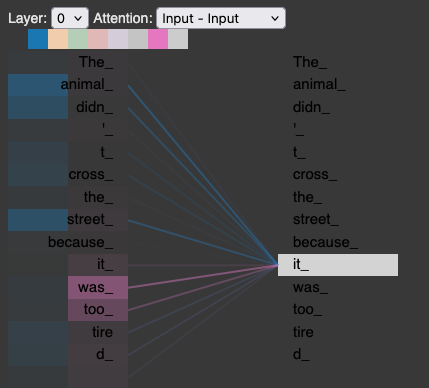

Self-attention mechanism helps the model to "learn" token's (here, a word) vector representation that takes "context" of the word, i.e. other tokens around a token, into consideration  This is called a **contextualised value vector** or context-aware vector.



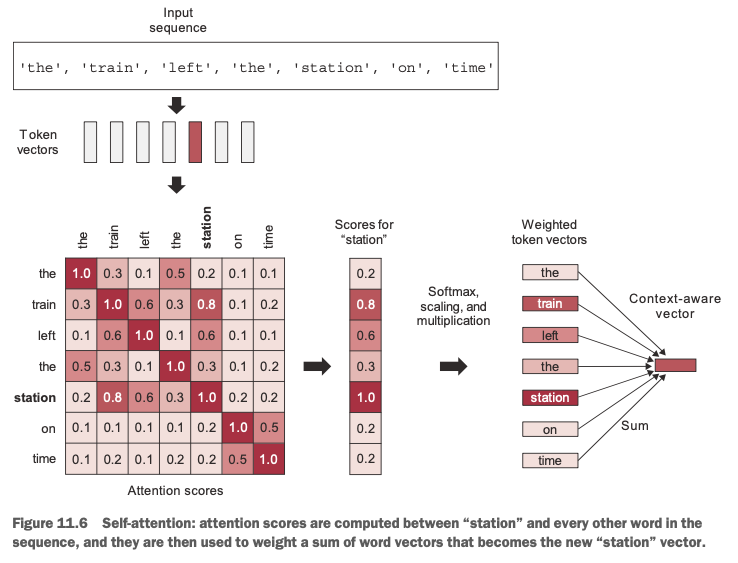

How is contextualised value vector computed? Generally, it is a result of multiplying 3 matrices, which are refered to as **Q(uery), K(ey), and V(alue)**. Let's try to clarify what their role is by examining this visualisation in Foster's (2023) textbook on Generative AI.

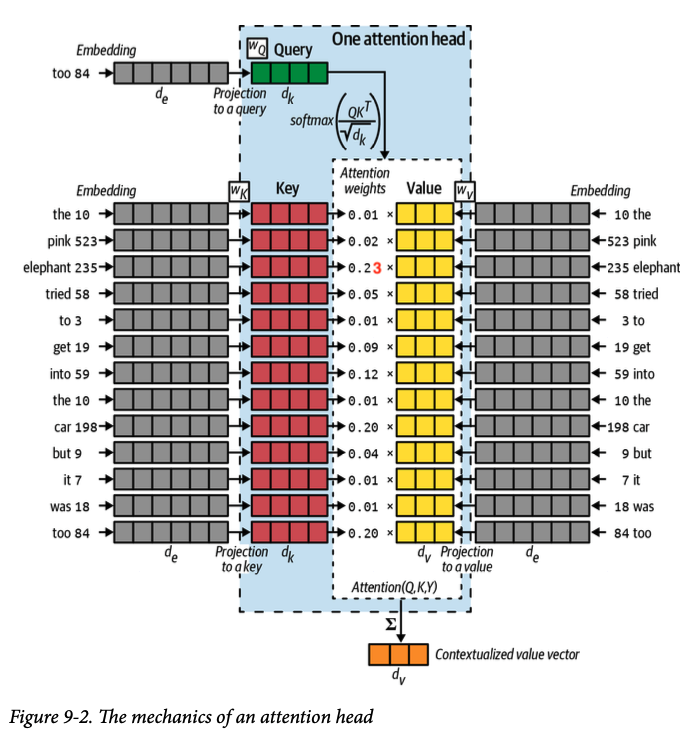

To decide which tokens are important, the attention head transforms the input into a *contextualised value vector*, which is meant to capture the meaning of an input, so the next word can be predicted.

Generally, the following steps are done to produce context-aware vector:
1. Compute a Query, which is a product of a query vector embedding (in the example above, it is an embedding for the word "too") and a matrix_wq.
2. Compute a Key, which is a product of vector embedding(s) coming before "too" and a matrix_wk.
  - Keys can be thought of as word representations in a sentence.
3. Keys are compared to the Query using dot product. The higher the number, the more significant the key is for the query.
  - the idea behind this is to have a Query matrix encode some information about words in the preceeding positions that might help to "answer" the question, "What is the next word?" Key is supposed to help to "answer" the question, hence why a larger number is interpreted as significant. For example, we might expect a query for "too" to capture information about "elephant", "car", and "into".
  - the resulting vector (after scaling and applying softmax) contains "attention weights"
4. Compute a Value, which is a product of word embedding and a matrix_wv. Value vectors (you can think of them as another representation of a word in a sentence) are multiplied by attention weights to produce "attention" for a given Q, K, V sets. The idea is that the value vector should change the word embedding in such a way as to reflext additional features about it, e.g. it's not any "too" but that which relates to the size of an elephant in relation to a car.
5. Finally, attention is summed up to produce context vector.

### Multihead Attention

However, there might be multiple ways in which we can attend to context. For example, we can pay attention to patterns of nouns or verbs. We can have multiple heads in a transformer, each of which should learn a distinct attention mechanism, thus encoding more complex relationships between Q, K, and V.

In Multihead attention, the same steps are followed as in self-attention, but we concatenate, instead of summing up, the outputs from each head to produce a new vector. It is passed through a matrix_wo to produce the output matrix.

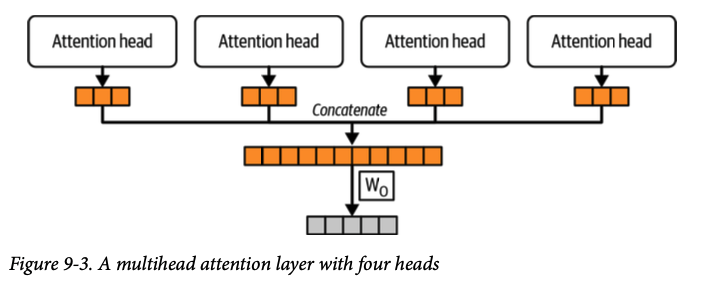

### Layer normalisation, feed-forward layers, and skip connections

**Layer normalisation** is used to stabilise training process.

**Skip connections** helps to minimise vanishing gradiet problem by providing deep neural networks with a way to transfer information forward.

**Feed-forward layers** (or densely connected layers) are included to extract high-dimensional features.



In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

    @classmethod
    def from_config(cls,config):
        return cls(**config)

## Attention mask function

Causal masking is a technique used to prevent "information leakage" in parallel sequence processing. It's a way to ensure that the GPT model does not "see" all the tokens at once, but only the ones that have come before it. Otherwise, it would be able to perfectly predict the next word by using the key of the next token.

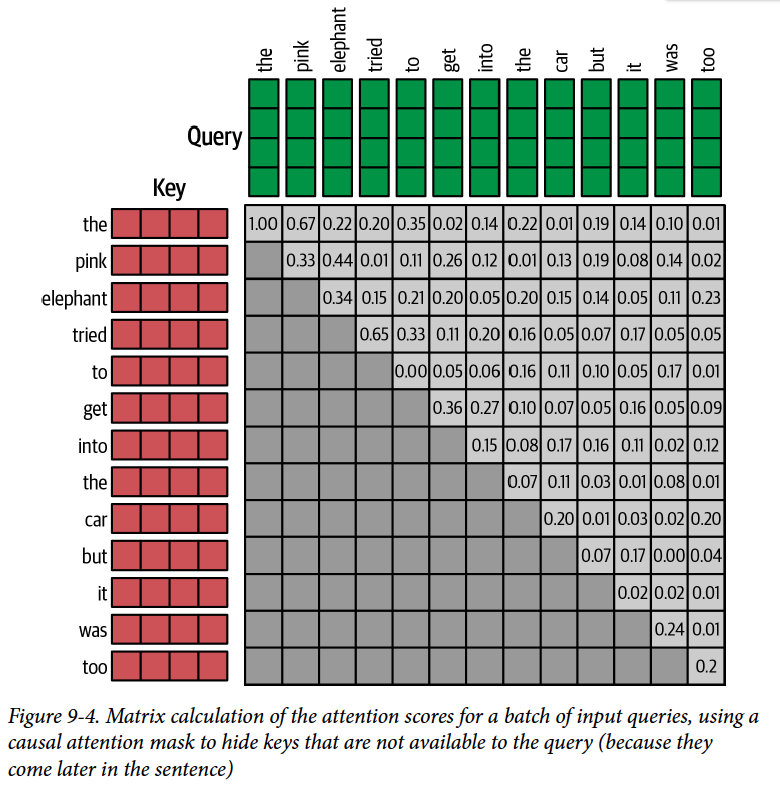

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## Build the Transformer model

Next, we will put all parts together to build a GPT. Some things to keep in mind:
1. Our model will have two heads as defined by N_HEADS variable.
2. Key (KEY_DIM) and embedding (EMBEDDING_DIM) dimensions are vectors of 256 elements each.
4. The feed-forward is a dense layer made up of 256 units (FEED_FORWARD_DIM).
3. Vocab size is 10k; these are 10k most common words in the dataset. The output of the dense layer will be 10k numbers which will add up to 1. The larger the token value is, the more the model "thinks" that it is the correct prediction.

The values of all the global variables can be modified, so feel free to experiment with, for instance, larger or smaller vocabularly size.

In [ ]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

In [ ]:
gpt.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 256)           │       2,580,480 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ [(None, None, 256), (None,  │         658,688 │
│                                      │ 2, None, None)]             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10000)         │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,809,168 (22.16 MB)

 Trainable params: 5,809,168 (22.16 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Transformer

Let's train the Transformer!

But first we will a function for text generation. We will also use this function during model training -- we will generate and display an example of a generated wine review after each epoch. This will help us to better understand model's improvement (or not) during the training.


In [ ]:
# Create a TextGenerator checkpoint
# This will return a sample of generated text after each epoch
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    # Below you can modify the parameters of the generated text
    # during the training process
    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", # prompt for starting a review
                      max_tokens=80, # length of the generated text
                      temperature=1.0) # between 0 (more "certain") and 1 (more "creative")

In [ ]:
# Tokenize starting prompt
# Starting prompt is "wine review"
text_generator = TextGenerator(vocab)

In [ ]:
gpt.fit(
    train_ds,
    epochs=EPOCHS, # 5
    callbacks=text_generator,
)

Epoch 1/5
4054/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5974
generated text:
wine review : us : california : pinot noir : one of the best avas in this tightly wound wine , with the strawberry and cranberry notes . it ' s rounded and fairly tannic , with cranberry and dried sour cherry to jump out of the glass . the finish vintner ' s most [UNK] those elements never [UNK] [UNK] those who interested in [UNK] ' s [UNK] lewellen 2013 , [UNK] to rocky cranberry and cut by a

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 431s 99ms/step - loss: 2.5967
Epoch 2/5
4054/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9819
generated text:
wine review : austria : südsteiermark : sauvignon blanc : a lick of flinty aspect runs from the nose to the palate , adding grapefruit and lemon freshness . . there ' s a taut , streamlined finish and crisp , but clean . there is a lovely freshness in cleansing direction . 

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 1.9818
Epoch 3/5
4052/4060 ━━━━━━━━━━━━━━━━━

In [ ]:
# Save the final model by uncommenting below
tf.saved_model.save(gpt, 'gpt.keras')

In [ ]:

# zip the folder with model parameters

import shutil
import zipfile
from google.colab import files
import os

def zip_folder(folder_path, output_zip_path):
    """Zips the contents of a folder into a zip file.

    Args:
        folder_path: The path to the folder to be zipped.
        output_zip_path: The path to the output zip file.
    """

    with zipfile.ZipFile(output_zip_path, "w") as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path)

if __name__ == "__main__":
    folder_path = "/content/gpt.keras" #Souce folder
    output_zip_path = "/content/gpt.zip" #zip file

    zip_folder(folder_path, output_zip_path)


# Download the zip file
files.download("/content/gpt.zip") #zip file path


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Text generation

Not only will we generate new reviews, but also we will visualise the text generation process. More specifically, we will a) highlight the words to which attention was paid when predicting the next word and b) output a list of words with the highest probabilities.

The darker the blue, the more attention was placed on that word. Note, that in our model we had two attention heads, so this is an average of the two.

In [ ]:
# Create a function to show the attention scores and word probabilities
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("------\n")

In [ ]:
# Generate a new wine review
# Show attention scores and word probabilities
info = text_generator.generate(
    "wine review : ", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review :  us : washington : cabernet sauvignon : this wine is 100 % varietal , with aromas of herb and cherry . the palate is medium bodied , with abundant notes of green herb and cherry . the flavors are light and elegant , with a lingering finish . 



us:   	79.19%
france:   	12.25%
italy:   	6.44%
spain:   	0.98%
chile:   	0.3%
------



::   	100.0%
-:   	0.0%
[UNK]:   	0.0%
blend:   	0.0%
grosso:   	0.0%
------



california:   	71.52%
washington:   	25.61%
oregon:   	2.58%
new:   	0.21%
virginia:   	0.07%
------



::   	100.0%
-:   	0.0%
du:   	0.0%
other:   	0.0%
[UNK]:   	0.0%
------



syrah:   	30.04%
cabernet:   	26.98%
bordeaux:   	22.06%
merlot:   	5.76%
red:   	4.85%
------



sauvignon:   	90.53%
franc:   	9.47%
blend:   	0.0%
merlot:   	0.0%
::   	0.0%
------



::   	99.99%
-:   	0.01%
blanc:   	0.0%
blend:   	0.0%
gris:   	0.0%
------



this:   	56.59%
the:   	30.74%
a:   	5.81%
aromas:   	4.08%
coming:   	0.48%
------



wine:   	65.05%
is:   	33.24%
100:   	0.81%
blend:   	0.49%
young:   	0.07%
------



is:   	82.89%
offers:   	9.35%
brings:   	1.93%
':   	1.02%
seems:   	0.97%
------



a:   	50.26%
100:   	25.34%
all:   	9.06%
the:   	4.5%
quite:   	1.53%
------



%:   	99.99%
-:   	0.01%
barrel:   	0.0%
g:   	0.0%
years:   	0.0%
------



varietal:   	98.31%
cabernet:   	1.44%
new:   	0.14%
wallula:   	0.05%
barrel:   	0.03%
------



,:   	95.32%
from:   	1.41%
.:   	1.05%
and:   	0.98%
with:   	0.5%
------



with:   	95.02%
from:   	1.58%
aged:   	0.72%
and:   	0.68%
barrel:   	0.65%
------



aromas:   	63.56%
notes:   	31.1%
barrel:   	2.41%
brooding:   	1.09%
the:   	0.71%
------



of:   	99.98%
that:   	0.01%
and:   	0.01%
suggesting:   	0.0%
coming:   	0.0%
------



herb:   	18.69%
tire:   	17.57%
dried:   	12.87%
herbs:   	8.61%
cherry:   	5.61%
------



,:   	97.43%
and:   	2.57%
(:   	0.0%
.:   	0.0%
along:   	0.0%
------



spice:   	41.61%
cherry:   	28.31%
dark:   	7.41%
barrel:   	4.2%
tire:   	3.36%
------



.:   	64.27%
,:   	27.14%
along:   	4.85%
followed:   	1.71%
fruit:   	0.87%
------



the:   	84.66%
it:   	12.73%
aromas:   	0.62%
brooding:   	0.53%
light:   	0.32%
------



palate:   	74.27%
aromas:   	8.96%
flavors:   	4.49%
fruit:   	4.16%
barrel:   	1.01%
------



brings:   	49.33%
is:   	40.54%
offers:   	4.14%
shows:   	3.71%
displays:   	0.75%
------



full:   	66.13%
medium:   	13.13%
light:   	5.63%
rich:   	2.71%
lighter:   	1.64%
------



bodied:   	91.82%
-:   	5.11%
sweet:   	2.45%
in:   	0.49%
to:   	0.11%
------



,:   	91.13%
with:   	5.98%
and:   	2.83%
in:   	0.03%
yet:   	0.01%
------



with:   	98.36%
showing:   	1.51%
full:   	0.05%
dry:   	0.01%
light:   	0.01%
------



a:   	39.42%
abundant:   	28.53%
lightly:   	6.12%
the:   	4.27%
tart:   	4.0%
------



cherry:   	32.32%
spice:   	12.14%
barrel:   	10.19%
savory:   	9.82%
vanilla:   	6.6%
------



of:   	99.85%
that:   	0.11%
seeming:   	0.02%
and:   	0.01%
showing:   	0.0%
------



dried:   	20.89%
sweet:   	15.65%
cocoa:   	12.52%
dark:   	10.02%
cherry:   	7.75%
------



herb:   	48.71%
herbs:   	27.67%
pepper:   	16.94%
plum:   	2.21%
olive:   	1.44%
------



,:   	80.57%
and:   	19.42%
.:   	0.01%
that:   	0.0%
along:   	0.0%
------



cherry:   	39.24%
spice:   	22.76%
barrel:   	13.27%
plum:   	5.25%
herb:   	4.14%
------



.:   	95.66%
,:   	2.75%
that:   	0.53%
flavors:   	0.31%
fruit:   	0.3%
------



it:   	53.72%
the:   	44.33%
:   	1.47%
a:   	0.17%
there:   	0.15%
------



tannins:   	38.04%
flavors:   	22.81%
oak:   	16.67%
fruit:   	5.62%
barrel:   	4.74%
------



are:   	96.59%
show:   	1.64%
persist:   	0.62%
have:   	0.36%
seem:   	0.3%
------



lighter:   	30.85%
light:   	16.68%
tart:   	13.14%
sweet:   	7.46%
broad:   	5.73%
------



and:   	66.47%
,:   	30.17%
but:   	1.89%
in:   	0.78%
bodied:   	0.31%
------



elegant:   	66.62%
silky:   	6.27%
reserved:   	6.2%
tart:   	3.87%
show:   	2.53%
------



,:   	96.05%
in:   	2.05%
.:   	1.41%
on:   	0.22%
with:   	0.19%
------



with:   	65.94%
showing:   	30.58%
but:   	1.25%
it:   	0.99%
and:   	0.33%
------



a:   	90.86%
the:   	3.18%
lightly:   	1.54%
an:   	1.29%
abundant:   	0.5%
------



lightly:   	17.66%
lingering:   	14.95%
silky:   	8.18%
pleasing:   	7.33%
fine:   	6.41%
------



finish:   	99.51%
,:   	0.24%
sense:   	0.06%
squeeze:   	0.04%
lick:   	0.03%
------



.:   	99.15%
that:   	0.83%
of:   	0.02%
caps:   	0.0%
showing:   	0.0%
------



:   	99.62%
it:   	0.34%
the:   	0.03%
drink:   	0.01%
a:   	0.0%
------



## Load the pre-trained GPT [to be fixed]

You can download the pre-trained GPT model. It was trained on 5 epochs as the

---

cell below shows.

---



In [ ]:
'''
gpt.fit(
    train_ds,
    epochs=5,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

'''


'\ngpt.fit(\n    train_ds,\n    epochs=25,\n    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],\n)\n\ngpt.save("/gpt")\n\n'

In [ ]:
# load up the GPT

file_id = "1dcPPoCUU5GG7C5lwiWUGvKs94jof7rya"
output_file = "gpt_students.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

!unzip -qq /content/gpt_students.zip -d gpt_students

Downloading...
From (original): https://drive.google.com/uc?id=1dcPPoCUU5GG7C5lwiWUGvKs94jof7rya
From (redirected): https://drive.google.com/uc?id=1dcPPoCUU5GG7C5lwiWUGvKs94jof7rya&confirm=t&uuid=ced0580f-42e3-4d80-b597-143594645d9d
To: /content/gpt_students.zip
100%|██████████| 70.0M/70.0M [00:00<00:00, 82.1MB/s]


In [ ]:
# gpt_25epochs = models.load_model("./gpt-25epochs/gpt-25epochs", compile=True)

gpt_reloaded = tf.keras.models.load_model("/content/gpt_students/content/gpt.keras")

ValueError: File not found: filepath=/content/gpt_students/content/gpt.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
print(gpt_reloaded.summary())

AttributeError: '_UserObject' object has no attribute 'summary'

### Text generation

In [ ]:
# Create TextGenerator
class TextGeneratorLoad():
    model = gpt_reloaded
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [ ]:
'''
A reminder that the function does the following:
a) highlights the words to which attention was paid when predicting the next
word;
b) outputs a list of words with the highest probabilities.

The darker the blue, the more attention was placed on that word.
Note, that in our model we had two attention heads, so this is an
average of the two.
'''

def print_probs(info, vocab, top_k = 5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
text_generator_load = TextGeneratorLoad(vocab, gpt_reloaded)

In [ ]:
# Generate a new wine review
# Show attention scores and word probabilities
info = text_generator_load.generate(
    "wine review : spain", # prompt
    max_tokens = 60, # generated review length (maximum number of characters)
    temperature= 0.1 # between 0 and 1;
)

print_probs(info, vocab, top_k=10)


generated text:
wine review : spain : northern spain : tempranillo : this is a big , ripe , jammy wine with a full - bodied , creamy mouthfeel and a touch of oak . flavors of plum , vanilla and spice are a bit warm and jammy , with a touch of vanilla . finishes with a touch of vanilla and



::   	100.0%
-:   	0.0%
celebrated:   	0.0%
coiled:   	0.0%
company:   	0.0%
confirms:   	0.0%
dotted:   	0.0%
during:   	0.0%
exquisitely:   	0.0%
grey:   	0.0%
--------



northern:   	100.0%
catalonia:   	0.0%
central:   	0.0%
galicia:   	0.0%
levante:   	0.0%
andalucia:   	0.0%
spain:   	0.0%
spanish:   	0.0%
southern:   	0.0%
piedmont:   	0.0%
--------



spain:   	100.0%
italy:   	0.0%
chile:   	0.0%
us:   	0.0%
france:   	0.0%
argentina:   	0.0%
central:   	0.0%
south:   	0.0%
northern:   	0.0%
austria:   	0.0%
--------



::   	100.0%
-:   	0.0%
grosso:   	0.0%
valley:   	0.0%
blanca:   	0.0%
region:   	0.0%
blanc:   	0.0%
du:   	0.0%
white:   	0.0%
celebrated:   	0.0%
--------



tempranillo:   	99.99%
garnacha:   	0.01%
red:   	0.0%
rosé:   	0.0%
mencía:   	0.0%
verdejo:   	0.0%
tinto:   	0.0%
rosado:   	0.0%
white:   	0.0%
tinta:   	0.0%
--------



::   	100.0%
blend:   	0.0%
-:   	0.0%
blanco:   	0.0%
grosso:   	0.0%
with:   	0.0%
blanc:   	0.0%
[UNK]:   	0.0%
and:   	0.0%
tintorera:   	0.0%
--------



this:   	100.0%
earthy:   	0.0%
a:   	0.0%
aromas:   	0.0%
the:   	0.0%
dark:   	0.0%
jammy:   	0.0%
[UNK]:   	0.0%
ripe:   	0.0%
rubbery:   	0.0%
--------



is:   	100.0%
smells:   	0.0%
wine:   	0.0%
has:   	0.0%
opens:   	0.0%
starts:   	0.0%
tempranillo:   	0.0%
reserva:   	0.0%
feels:   	0.0%
[UNK]:   	0.0%
--------



a:   	100.0%
an:   	0.0%
the:   	0.0%
one:   	0.0%
full:   	0.0%
dark:   	0.0%
jammy:   	0.0%
solid:   	0.0%
tight:   	0.0%
not:   	0.0%
--------



big:   	99.05%
solid:   	0.79%
full:   	0.13%
very:   	0.02%
ripe:   	0.0%
dark:   	0.0%
bit:   	0.0%
blend:   	0.0%
pure:   	0.0%
good:   	0.0%
--------



,:   	100.0%
wine:   	0.0%
and:   	0.0%
but:   	0.0%
-:   	0.0%
step:   	0.0%
bruiser:   	0.0%
[UNK]:   	0.0%
red:   	0.0%
one:   	0.0%
--------



ripe:   	99.45%
full:   	0.31%
jammy:   	0.16%
bold:   	0.07%
rich:   	0.02%
tannic:   	0.0%
chunky:   	0.0%
modern:   	0.0%
lusty:   	0.0%
extracted:   	0.0%
--------



,:   	100.0%
wine:   	0.0%
and:   	0.0%
rioja:   	0.0%
style:   	0.0%
specimen:   	0.0%
bruiser:   	0.0%
but:   	0.0%
vintage:   	0.0%
tempranillo:   	0.0%
--------



full:   	55.19%
jammy:   	44.81%
modern:   	0.01%
rich:   	0.0%
raisiny:   	0.0%
ripe:   	0.0%
almost:   	0.0%
creamy:   	0.0%
oaky:   	0.0%
bold:   	0.0%
--------



wine:   	100.0%
style:   	0.0%
,:   	0.0%
and:   	0.0%
nose:   	0.0%
tempranillo:   	0.0%
red:   	0.0%
type:   	0.0%
bouquet:   	0.0%
rioja:   	0.0%
--------



with:   	100.0%
that:   	0.0%
,:   	0.0%
.:   	0.0%
loaded:   	0.0%
from:   	0.0%
made:   	0.0%
and:   	0.0%
to:   	0.0%
whose:   	0.0%
--------



a:   	89.87%
blackberry:   	6.41%
black:   	2.03%
aromas:   	1.21%
jammy:   	0.4%
baked:   	0.03%
plum:   	0.02%
berry:   	0.02%
raisin:   	0.0%
raspberry:   	0.0%
--------



full:   	78.24%
lot:   	16.23%
touch:   	5.13%
mix:   	0.18%
jammy:   	0.13%
ton:   	0.04%
blast:   	0.03%
bit:   	0.0%
little:   	0.0%
good:   	0.0%
--------



-:   	77.65%
,:   	22.35%
body:   	0.0%
blast:   	0.0%
mouthfeel:   	0.0%
bouquet:   	0.0%
outlook:   	0.0%
feel:   	0.0%
and:   	0.0%
but:   	0.0%
--------



bodied:   	100.0%
force:   	0.0%
bore:   	0.0%
throttle:   	0.0%
volume:   	0.0%
load:   	0.0%
fruited:   	0.0%
flavored:   	0.0%
throttled:   	0.0%
body:   	0.0%
--------



,:   	99.99%
feel:   	0.01%
mouthfeel:   	0.0%
character:   	0.0%
mix:   	0.0%
balance:   	0.0%
but:   	0.0%
palate:   	0.0%
nose:   	0.0%
texture:   	0.0%
--------



creamy:   	81.73%
ripe:   	16.3%
modern:   	1.2%
almost:   	0.45%
tannic:   	0.13%
rich:   	0.1%
jammy:   	0.09%
saturated:   	0.01%
lush:   	0.0%
chewy:   	0.0%
--------



mouthfeel:   	79.57%
palate:   	19.94%
nose:   	0.3%
feel:   	0.19%
texture:   	0.01%
,:   	0.0%
bouquet:   	0.0%
and:   	0.0%
wine:   	0.0%
feeling:   	0.0%
--------



and:   	99.98%
.:   	0.02%
that:   	0.0%
,:   	0.0%
housing:   	0.0%
with:   	0.0%
along:   	0.0%
is:   	0.0%
houses:   	0.0%
but:   	0.0%
--------



a:   	99.98%
flavors:   	0.02%
soft:   	0.0%
full:   	0.0%
ripe:   	0.0%
rich:   	0.0%
jammy:   	0.0%
firm:   	0.0%
creamy:   	0.0%
good:   	0.0%
--------



touch:   	99.99%
bit:   	0.01%
lot:   	0.0%
full:   	0.0%
little:   	0.0%
hint:   	0.0%
sense:   	0.0%
smooth:   	0.0%
good:   	0.0%
big:   	0.0%
--------



of:   	100.0%
flat:   	0.0%
baked:   	0.0%
raisiny:   	0.0%
sticky:   	0.0%
creamy:   	0.0%
syrupy:   	0.0%
like:   	0.0%
to:   	0.0%
lactic:   	0.0%
--------



oak:   	99.89%
raisin:   	0.11%
vanilla:   	0.01%
spice:   	0.0%
black:   	0.0%
wood:   	0.0%
baked:   	0.0%
caramel:   	0.0%
sweet:   	0.0%
blackberry:   	0.0%
--------



.:   	74.77%
,:   	25.18%
and:   	0.06%
that:   	0.0%
along:   	0.0%
-:   	0.0%
on:   	0.0%
influence:   	0.0%
to:   	0.0%
aromas:   	0.0%
--------



flavors:   	100.0%
toasty:   	0.0%
the:   	0.0%
baked:   	0.0%
plum:   	0.0%
aromas:   	0.0%
blackberry:   	0.0%
black:   	0.0%
dark:   	0.0%
spicy:   	0.0%
--------



of:   	100.0%
are:   	0.0%
include:   	0.0%
run:   	0.0%
suggest:   	0.0%
,:   	0.0%
resemble:   	0.0%
match:   	0.0%
[UNK]:   	0.0%
come:   	0.0%
--------



plum:   	99.03%
blackberry:   	0.82%
black:   	0.12%
cherry:   	0.02%
raspberry:   	0.01%
vanilla:   	0.0%
baked:   	0.0%
raisin:   	0.0%
berry:   	0.0%
spiced:   	0.0%
--------



and:   	51.45%
,:   	48.55%
skins:   	0.0%
are:   	0.0%
cake:   	0.0%
sauce:   	0.0%
pudding:   	0.0%
skin:   	0.0%
juice:   	0.0%
kool:   	0.0%
--------



vanilla:   	84.97%
blackberry:   	13.68%
cherry:   	1.17%
raspberry:   	0.09%
berry:   	0.09%
spice:   	0.0%
cassis:   	0.0%
black:   	0.0%
plum:   	0.0%
raisin:   	0.0%
--------



and:   	95.37%
,:   	4.63%
cream:   	0.0%
bean:   	0.0%
extract:   	0.0%
cake:   	0.0%
cookies:   	0.0%
oak:   	0.0%
are:   	0.0%
-:   	0.0%
--------



spice:   	99.11%
chocolate:   	0.75%
cherry:   	0.1%
toast:   	0.04%
oak:   	0.0%
coconut:   	0.0%
berry:   	0.0%
vanilla:   	0.0%
mocha:   	0.0%
wood:   	0.0%
--------



are:   	98.55%
accent:   	1.45%
finish:   	0.0%
cover:   	0.0%
,:   	0.0%
blend:   	0.0%
cake:   	0.0%
come:   	0.0%
lead:   	0.0%
run:   	0.0%
--------



a:   	99.43%
smooth:   	0.29%
ripe:   	0.19%
lightly:   	0.08%
toasty:   	0.01%
full:   	0.0%
solid:   	0.0%
chocolaty:   	0.0%
mildly:   	0.0%
backed:   	0.0%
--------



bit:   	100.0%
touch:   	0.0%
little:   	0.0%
hint:   	0.0%
mix:   	0.0%
good:   	0.0%
smooth:   	0.0%
note:   	0.0%
long:   	0.0%
fine:   	0.0%
--------



flat:   	54.93%
more:   	23.32%
warm:   	9.38%
hot:   	4.76%
baked:   	2.71%
rough:   	2.41%
heavy:   	1.72%
green:   	0.52%
sweet:   	0.13%
oaky:   	0.04%
--------



and:   	86.53%
,:   	13.46%
.:   	0.0%
on:   	0.0%
but:   	0.0%
in:   	0.0%
for:   	0.0%
with:   	0.0%
as:   	0.0%
compared:   	0.0%
--------



jammy:   	79.35%
chocolaty:   	14.49%
baked:   	2.42%
raisiny:   	1.5%
oaky:   	0.85%
ripe:   	0.54%
toasty:   	0.5%
creamy:   	0.24%
rich:   	0.05%
warm:   	0.05%
--------



,:   	97.55%
.:   	2.45%
on:   	0.0%
in:   	0.0%
but:   	0.0%
as:   	0.0%
and:   	0.0%
at:   	0.0%
;:   	0.0%
than:   	0.0%
--------



with:   	99.98%
while:   	0.02%
but:   	0.0%
and:   	0.0%
which:   	0.0%
like:   	0.0%
as:   	0.0%
so:   	0.0%
yet:   	0.0%
without:   	0.0%
--------



a:   	100.0%
baked:   	0.0%
blackberry:   	0.0%
black:   	0.0%
ripe:   	0.0%
flavors:   	0.0%
good:   	0.0%
toasty:   	0.0%
plum:   	0.0%
sweet:   	0.0%
--------



touch:   	99.97%
hint:   	0.02%
toasty:   	0.0%
long:   	0.0%
mix:   	0.0%
bit:   	0.0%
creamy:   	0.0%
chocolaty:   	0.0%
good:   	0.0%
finish:   	0.0%
--------



of:   	100.0%
baked:   	0.0%
,:   	0.0%
more:   	0.0%
and:   	0.0%
that:   	0.0%
herbal:   	0.0%
like:   	0.0%
to:   	0.0%
on:   	0.0%
--------



oak:   	91.65%
vanilla:   	6.73%
heat:   	0.81%
raisin:   	0.78%
bitterness:   	0.03%
sweetness:   	0.0%
chocolate:   	0.0%
baked:   	0.0%
black:   	0.0%
blackberry:   	0.0%
--------



and:   	95.33%
.:   	4.67%
,:   	0.0%
on:   	0.0%
that:   	0.0%
as:   	0.0%
oak:   	0.0%
to:   	0.0%
along:   	0.0%
accenting:   	0.0%
--------



finishes:   	96.52%
a:   	1.65%
the:   	1.56%
it:   	0.27%
toasty:   	0.0%
:   	0.0%
drink:   	0.0%
flavors:   	0.0%
this:   	0.0%
good:   	0.0%
--------



with:   	100.0%
warm:   	0.0%
toasty:   	0.0%
creamy:   	0.0%
long:   	0.0%
jammy:   	0.0%
full:   	0.0%
dark:   	0.0%
on:   	0.0%
dry:   	0.0%
--------



a:   	100.0%
plum:   	0.0%
toasty:   	0.0%
black:   	0.0%
vanilla:   	0.0%
some:   	0.0%
mocha:   	0.0%
chocolate:   	0.0%
dark:   	0.0%
heat:   	0.0%
--------



touch:   	87.15%
blast:   	12.17%
toasty:   	0.6%
bit:   	0.06%
hint:   	0.02%
note:   	0.01%
little:   	0.0%
good:   	0.0%
chocolaty:   	0.0%
dark:   	0.0%
--------



of:   	100.0%
,:   	0.0%
and:   	0.0%
more:   	0.0%
green:   	0.0%
herbal:   	0.0%
.:   	0.0%
baked:   	0.0%
that:   	0.0%
sweet:   	0.0%
--------



heat:   	70.19%
vanilla:   	29.01%
oak:   	0.66%
bitterness:   	0.11%
chocolate:   	0.01%
spice:   	0.01%
raisin:   	0.01%
burnt:   	0.0%
toast:   	0.0%
toasty:   	0.0%
--------



and:   	99.53%
.:   	0.47%
,:   	0.0%
but:   	0.0%
as:   	0.0%
cream:   	0.0%
flavor:   	0.0%
or:   	0.0%
sweetness:   	0.0%
bean:   	0.0%
--------



In [ ]:
# You can play around with the hyperparameters to see how it changes the output.
# For instance, if you set the generated review length to 20, you will notice that
# the model generates reviews that look unfinished, e.g. a dot is missing.
# This is because we trained it on reviews which had a length of 80 tokens, so
# the module "assumes" that it has this much space for text generation.

info = text_generator_load.generate(
    "wine review : italy", # prompt
    max_tokens = 20, # generated review length (maximum number of characters)
    temperature= 0.8 # between 0 and 1;
)

print_probs(info, vocab, top_k=3)


generated text:
wine review : italy : piedmont : nebbiolo : from a [UNK] vineyard planted in 1997 , this charming and



::   	100.0%
grosso:   	0.0%
other:   	0.0%
--------



tuscany:   	46.77%
piedmont:   	14.6%
sicily:   	12.26%
--------



::   	100.0%
grosso:   	0.0%
-:   	0.0%
--------



nebbiolo:   	88.84%
barbera:   	3.73%
dolcetto:   	2.4%
--------



::   	100.0%
grosso:   	0.0%
-:   	0.0%
--------



this:   	41.99%
aromas:   	30.52%
[UNK]:   	2.47%
--------



the:   	65.84%
one:   	23.23%
a:   	3.82%
--------



single:   	31.01%
vineyard:   	22.47%
selection:   	3.46%
--------



vineyard:   	26.25%
-:   	16.51%
of:   	10.81%
--------



in:   	47.71%
located:   	23.82%
planted:   	5.18%
--------



in:   	73.26%
to:   	15.53%
on:   	3.23%
--------



[UNK]:   	78.84%
2001:   	6.82%
the:   	3.94%
--------



,:   	97.83%
and:   	1.79%
.:   	0.11%
--------



this:   	58.21%
the:   	14.56%
at:   	5.25%
--------



wine:   	22.28%
opens:   	19.17%
is:   	12.86%
--------



wine:   	67.29%
,:   	19.41%
and:   	6.69%
--------



## Resources

Original transformer architecture:
- Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. 2023. “Attention Is All You Need.” arXiv. https://doi.org/10.48550/arXiv.1706.03762.
- Uszkoreit, Jakob. 2017. “Transformer: A Novel Neural Network Architecture for Language Understanding.” Google Research Blog. August 31, 2017. https://blog.research.google/2017/08/transformer-novel-neural-network.html.


GPT:
- Radford, Alec. 2018. “Improving Language Understanding with Unsupervised Learning.” OpenAI. 2018. https://openai.com/research/language-unsupervised.
- Radford, Alec, Jeffrey Wu, Dario Amodei, Daniella Amodei, Jack Clark, Miles Brundage, and Ilya Sutskever. 2019. “Better Language Models and Their Implications.” OpenAI. 2019. https://openai.com/research/better-language-models#sample1.


BERT's attention analysis:
- Clark, Kevin, Urvashi Khandelwal, Omer Levy, and Christopher D. Manning. 2019. “What Does BERT Look At? An Analysis of BERT’s Attention.” arXiv. https://doi.org/10.48550/arXiv.1906.04341.

Textbooks and tutorials:
- Foster, David. 2023. Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play. 2nd edition. Beijing Boston Farnham Sebastopol Tokyo: Oreilly & Associates Inc.
  - chapter 9; code https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/09_transformer/gpt/gpt.ipynb
- Glassner, Andrew. 2021. Deep Learning: A Visual Approach. Illustrated edition. San Francisco: No Starch Press.
  - chapter 20
- Tunstall, Lewis, Leandro von Werra, and Thomas Wolf. 2022. Natural Language Processing with Transformers, Revised Edition. 1st edition, Revised. Sebastopol, CA: O’Reilly Media.
  - chapters 1 and 3
- Alammar, Jay. 2018. “The Illustrated Transformer.” 2018. http://jalammar.github.io/illustrated-transformer/.
- Tensorflow's transformer tutorial for machine translation: https://www.tensorflow.org/text/tutorials/transformer
- 3Blue1Brown tutorial: https://www.youtube.com/watch?v=eMlx5fFNoYc
